In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import hierarchical
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
import csv
import math
from random import randint
from scipy import stats
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import chisquare
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabaz_score
from math import pi

1. cohort clustering: find the best k

In [2]:
def elbow_method(X):
    '''
    Using elbow method to find the best k of the kmeans.
    X is feature matrix.
    '''
    # distortions = []
    distorsion = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)   
        distorsion.append(kmeanModel.inertia_)
    
    fig = plt.figure(figsize=(15, 5))
    plt.grid(True)
    plt.plot(range(2, 15), distorsion)
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.savefig('The Elbow Method showing the optimal k')
    plt.show()

In [3]:
def cal_avg(data):
    result = []
    total = [0 for i in range(len(data[0][0]))]
    for da in data:
        oneline = [0 for i in range(len(da[0]))]
        max_ele = [0 for i in range(len(da[0]))]
        for i in range(len(da)):
            for j in range(len(da[i])):
                oneline[j] = oneline[j] + int(da[i][j])
                total[j] = total[j] + int(da[i][j])
                if int(da[i][j]) > max_ele[j]:
                    max_ele[j] = int(da[i][j])
        for i in range(len(oneline)):
            if oneline[i]!=0:
                oneline[i] = oneline[i]/float(max_ele[i])/float(len(da))
        result.append(oneline)
    for i in range(len(total)):
        total[i] = total[i] / float(123)
    return result, total

In [4]:
def radar(cat, data):
    '''
    category: attributes' names
    data: shape: 3d-list
    '''
#     index that weight is non zero
    diff = diff=[4,5,6,7,8,9,10,15,17,21,23]
    number = [55,13,49,6]
    colors = ['#5a9c4b', '#d58edc', '#5dc2c4', '#ec615c', 'm']
    colors = colors[:len(data)]
    each_group, total = cal_avg(data)

    new_cat = []
    new_each_group = [[] for i in range(len(each_group))]
    new_total = []
    for i in range(len(cat)):
        if i in diff:
            new_cat.append(cat[i])
            new_total.append(total[i])
    for i in range(len(each_group)):
        for j in range(len(each_group[i])):
            if j in diff:
                new_each_group[i].append(each_group[i][j])
    #total = new_total
    each_group = new_each_group
    cat = new_cat
    N = len(cat)
    for values, color, ii in zip(each_group, colors, range(len(data))):
        plt.figure(ii+2, figsize=(9,7))

        x_as = [n / float(N) * 2 * pi for n in range(N)]

        # Because our chart will be circular we need to append a copy of the first
        # value of each list at the end of each list with data
        values += values[:1]
        x_as += x_as[:1]

        # Set color of axes
        plt.rc('axes', linewidth=0.5, edgecolor="#888888")

        # Create polar plot
        ax = plt.subplot(111, polar=True)
#         ax.set_size_inches(9, 7)
        # Set clockwise rotation. That is:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        # Set color and linestyle of grid
        ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
        ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
        



        # Set number of radial axes and remove labels
        plt.xticks(x_as[:-1], [])

        # Set yticks
        plt.yticks([0.2, 0.4, 0.6, 0.8, 1], ["0.2", "0.4", "0.6", "0.8", "1"])

        # Plot data
        ax.plot(x_as, values, color, linewidth=1.5, linestyle='solid', zorder=3)

        # Fill area
        ax.fill(x_as, values, color, alpha=0.45)

        # Set axes limits
        plt.ylim(0, 1)

        # Draw ytick labels to make sure they fit properly
        for i in range(N):
            angle_rad = i / float(N) * 2 * pi

            if angle_rad == 0:
                ha, distance_ax = "center", 1
            elif 0 < angle_rad < pi:
                ha, distance_ax = "left", 1
            elif angle_rad == pi:
                ha, distance_ax = "center", 1
            else:
                ha, distance_ax = "right", 1

            ax.text(angle_rad,  0.08  + distance_ax, cat[i], size=15, horizontalalignment=ha, verticalalignment="center")

        font = {'family': 'serif',
            'color':  colors[ii],
            'weight': 'normal',
            'size': 25}
        plt.text(0.25, 1.25, 'Cohort '+ str(ii)+' (' +str(number[ii]) +')', fontdict = font)
        plt.show()

In [11]:
def silhouette_score_analysis(X):
    ''' 
    Do silhouette analysis and make plots 
    X : feature matrix 
    
    '''
    avr_ss = []
    range_n_clusters = range(2,10)
    for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)
        

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        avr_ss.append(silhouette_avg)
#         print("For n_clusters = "+str(n_clusters) +" The average silhouette_score is :"+ str(silhouette_avg))

    # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.Spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = plt.cm.Spectral(cluster_labels.astype(float) / n_clusters)
        X = PCA(n_components=2).fit_transform(X)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=4, alpha=0.7,
                c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    
    
    K = range_n_clusters
    
    
    plt.figure(figsize=(9, 7))
    plt.plot(K, avr_ss, 'bx-')
    plt.title('The Silhouette score with different k')
    plt.xlabel('Number of Clusters',fontsize = 15)
    plt.ylabel('Average Silhouette Score',fontsize =15)
    plt.grid(True)
    plt.show()

2.The weights we used are from the Greedy Search Algorithm

In [12]:
def main(filename):
    '''
    first: explore optimal number of clusters
    second: visualize kmeans and hierarchical clustering 
    @Parameter
    filename: the name of a csv file
    w: learnt weights for feature
    k: number of clusters for k means
    '''

    w = [0.0, 0.0, 0.0, 0.0, 0.1428571428571428, 1.0, 1.3095238095238089, 0.8095238095238084, 0.0, 0.8095238095238084, 1.0, 0.0, 0.0, 0.0, 0.0, 0.1428571428571428, 0.0, 0.1428571428571428, 0.0, 0.0, 0.0, 2.3928571428571423, 0.0, 
    0.25, 0.0, 0.0]
    k =4
    data = pd.read_csv(filename)
    feature = np.array(data.drop('id',axis =1,inplace=False))
    weighted_feature = (w * feature)
    X = weighted_feature
    silhouette_score_analysis(X)
    elbow_method(X)
    
    range_n_clusters = [ 3,4 ]

    for n_clusters in range_n_clusters:
        print("Now number of clusters:" + str(n_clusters))
    # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        y_lower = 10

        clusterer_1 = KMeans(n_clusters=n_clusters)
        cluster_labels_1 = clusterer_1.fit_predict(feature)
        X_1 = PCA(n_components=2).fit_transform(feature)
        colors = ['#5a9c4b', '#d58edc',  '#ec615c','#5dc2c4']
        markers =['X','o','^','d'];
        for i in range(len(X_1)):
            ax1.scatter(X_1[i, 0], X_1[i, 1], marker=markers[cluster_labels_1[i]], s=100, lw=0, alpha=1,
                    c= colors[cluster_labels_1[i]], edgecolor='k')
        ax1.set_xlabel("Feature projection to x feature space",fontsize=15,labelpad= 10)
        ax1.set_ylabel("Feature projection to y feature space",fontsize=15,labelpad= 10)
    
        clusterer = KMeans(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)
        X = PCA(n_components=2).fit_transform(weighted_feature)

        colors = plt.cm.Spectral(cluster_labels.astype(float) / n_clusters)
        colors = ['#5a9c4b', '#d58edc', '#5dc2c4', '#ec615c']
        markers =['X','o','d','^'];
        for i in range(len(X)):
            ax2.scatter(X[i, 0], X[i, 1], marker=markers[cluster_labels[i]], s=100, lw=0, alpha=0.95,
                c= colors[cluster_labels[i]], edgecolor='k')

    # Labeling the clusters
        centers = clusterer.cluster_centers_

        ax2.set_xlabel("Feature projection to x feature space",fontsize=15,labelpad= 10)
        ax2.set_ylabel("Feature projection to y feature space",fontsize=15,labelpad= 10)
        
        
        plt.show()
        plt.savefig("kmeans_k_" +str(n_clusters) )
        print("------------------------------------------------------------------------------")
        

    # draw hierachical clustering dendrogrm 
    print ('Hierachical dendrogram')
    link ='ward'
    ac = AgglomerativeClustering(linkage=link, n_clusters=4)
    ac.fit(weighted_feature)
    Z = hierarchy.linkage(weighted_feature, 'ward')
    plt.figure(figsize=(9, 7))
    plt.xlabel('Index',fontsize = 15)
    plt.ylabel('Distance',fontsize = 15)
    print('n = ', 4)
    hierarchy.dendrogram(Z,leaf_rotation=90.,  # rotates the x axis 
                         leaf_font_size=8.,  # font size for the x axis labels
                         color_threshold =4,no_labels =True
    )
    plt.show()

    kl = cluster_labels
    kmeans = KMeans(n_clusters= 4)
    kmeans.fit(weighted_feature)
    kl = kmeans.labels_ 
#     exchange labels to make color consistent with Hierachical Dendrogram

    for idx in range(len(kl)):
        if kl[idx] == 0:
            kl[idx] == 2
        elif kl[idx] == 1:
            kl[idx] == 0
        elif kl[idx] == 3:
            kl[idx] == 1  
            
    group_member =[]
    attr_no_ids =[]
    for k in range(0,4):
        id_list =[]
        attr=[]
        for i in range(len(data)):   
            if(kl[i] == k):
                id_list.append(int(data.iloc[i]['id']))
                attr.append(feature[i])
        group_member.append(id_list)
        attr_no_ids.append(attr)
        
    attr_names =data.columns[1:]
    radar(attr_names,attr_no_ids)
    

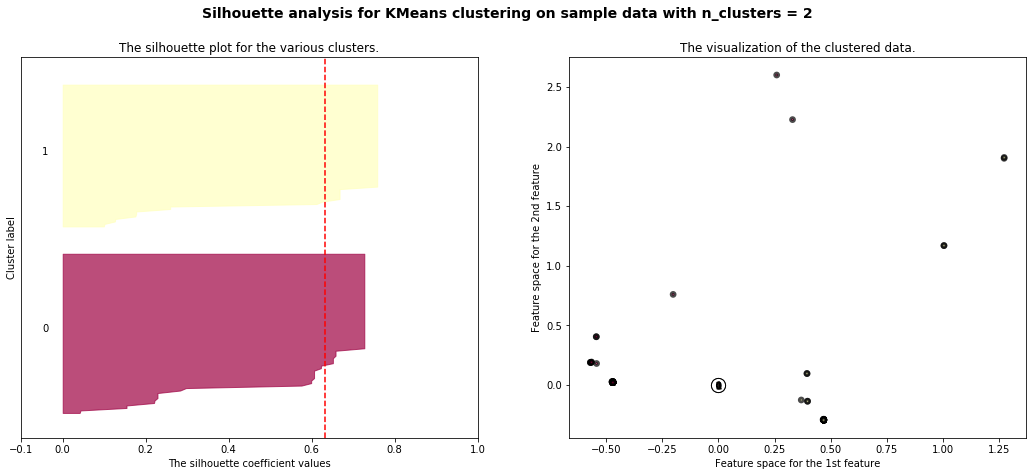

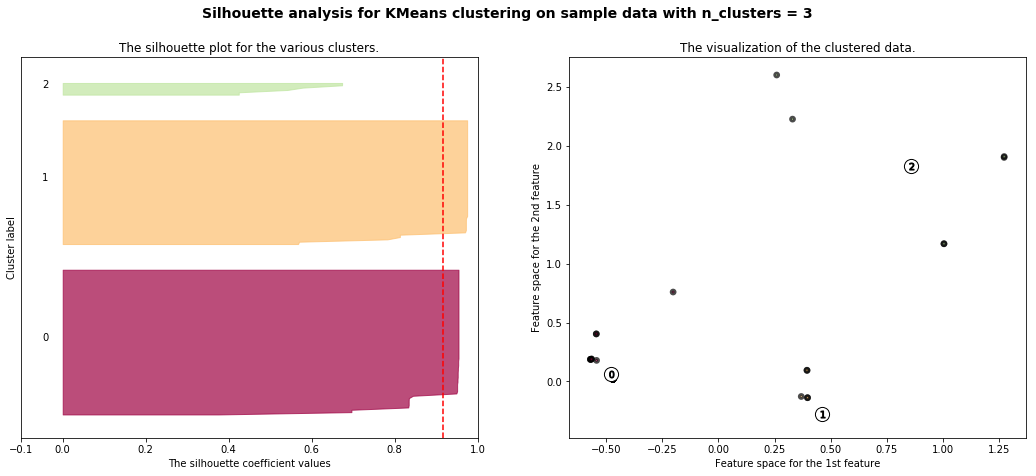

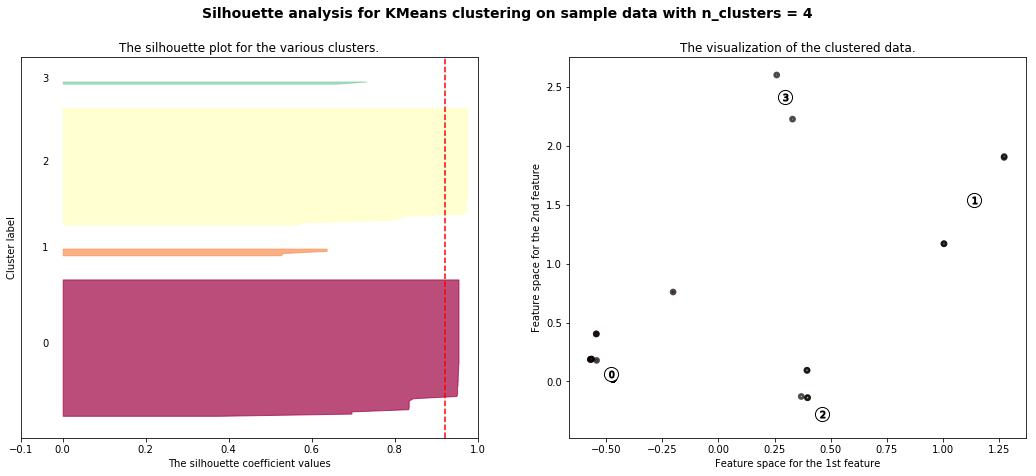

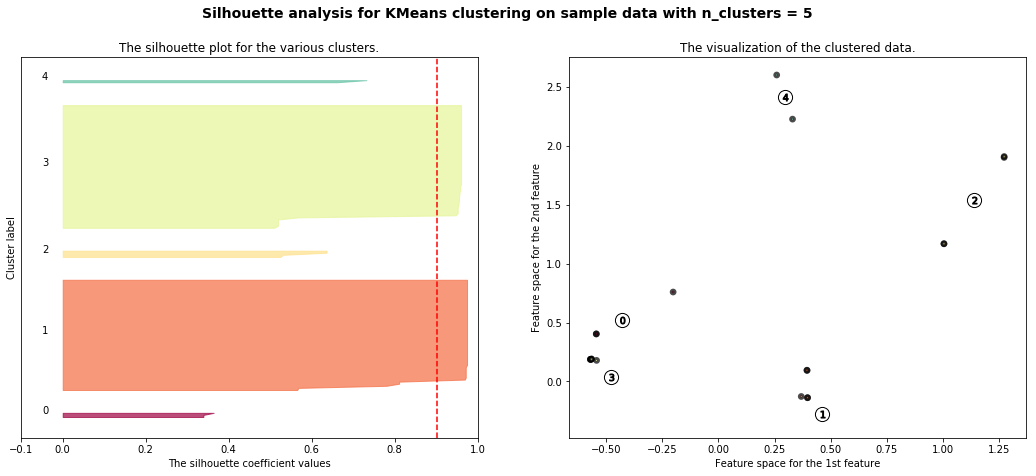

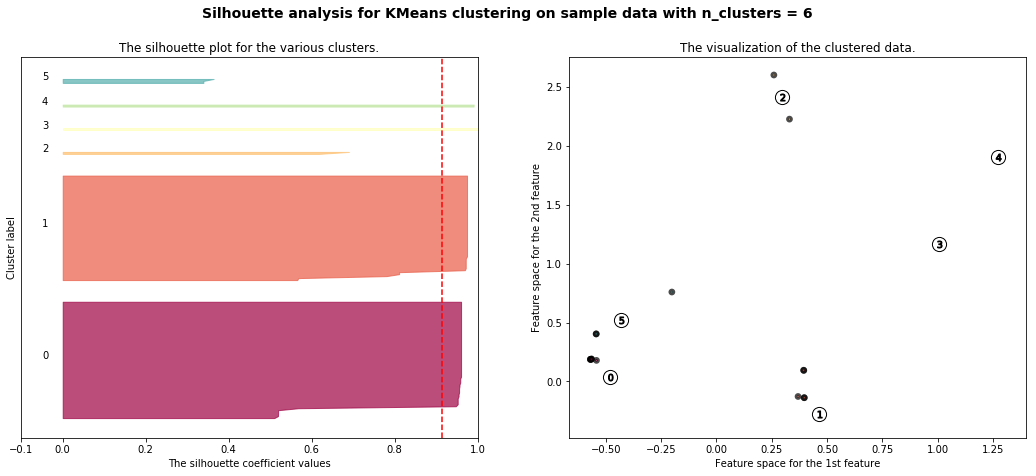

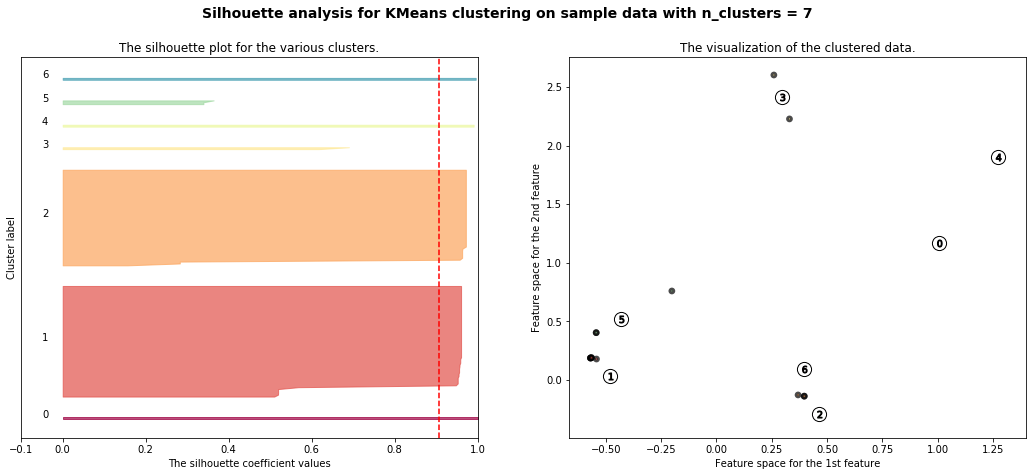

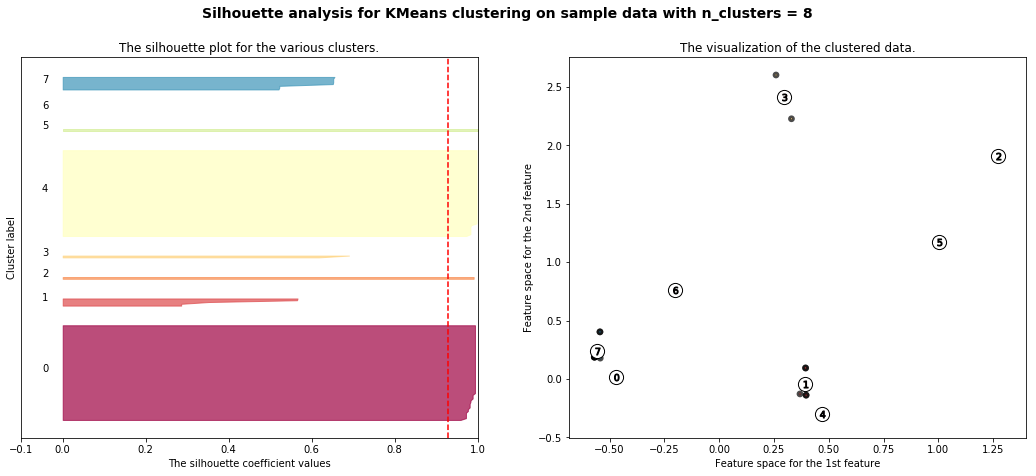

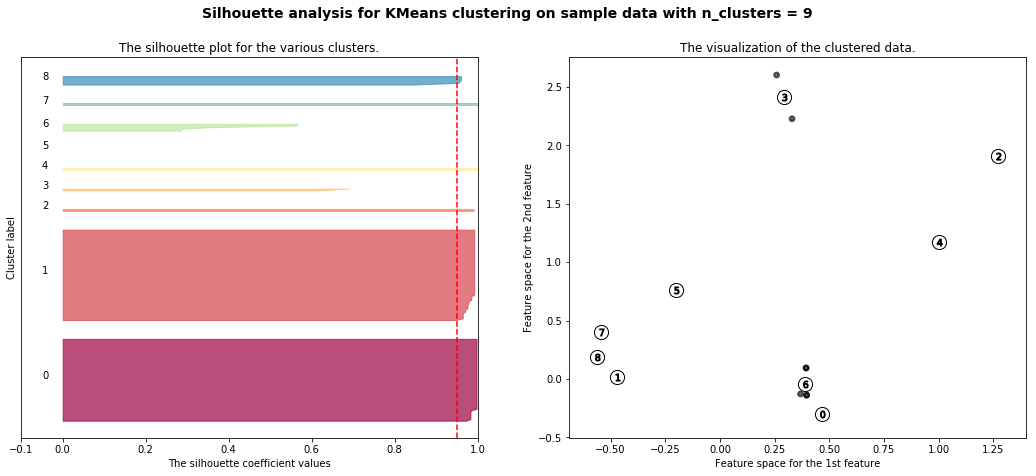

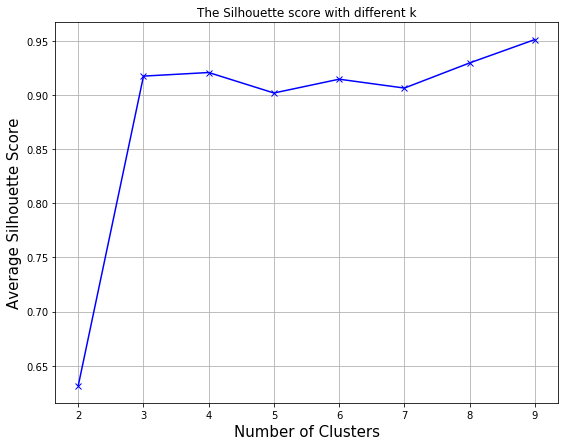

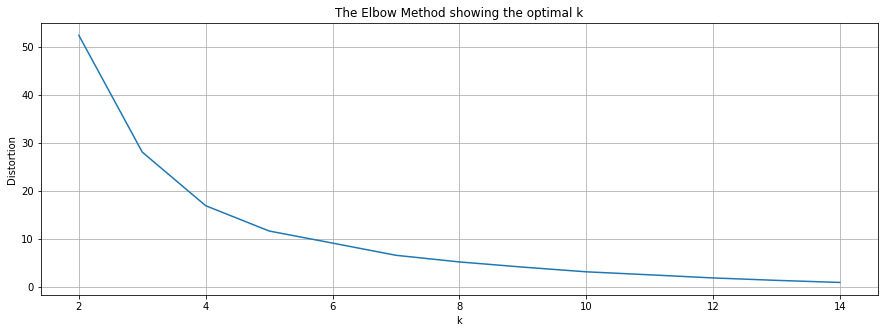

Now number of clusters:3


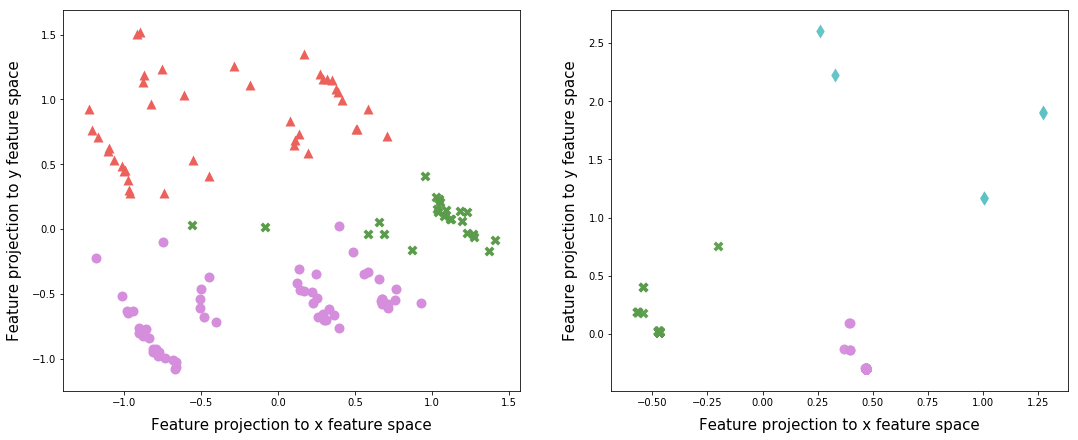

------------------------------------------------------------------------------
Now number of clusters:4


<Figure size 432x288 with 0 Axes>

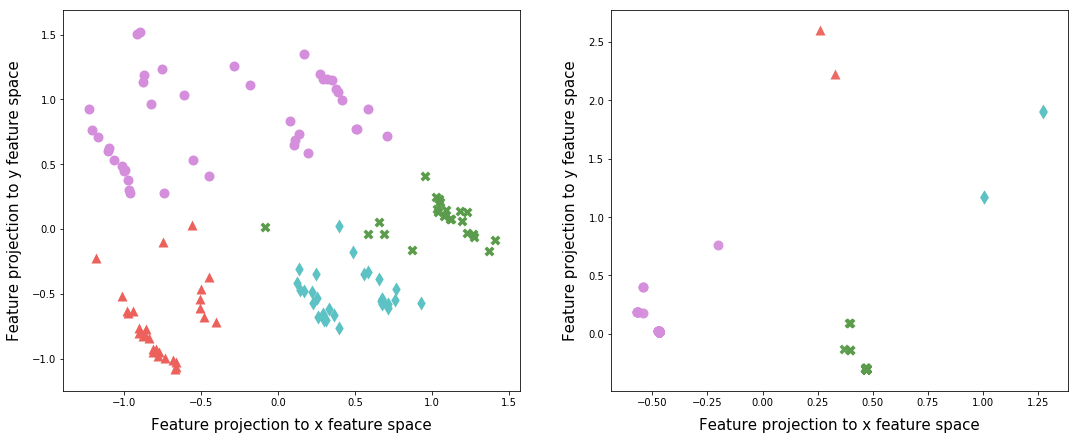

------------------------------------------------------------------------------
Hierachical dendrogram
n =  4


<Figure size 432x288 with 0 Axes>

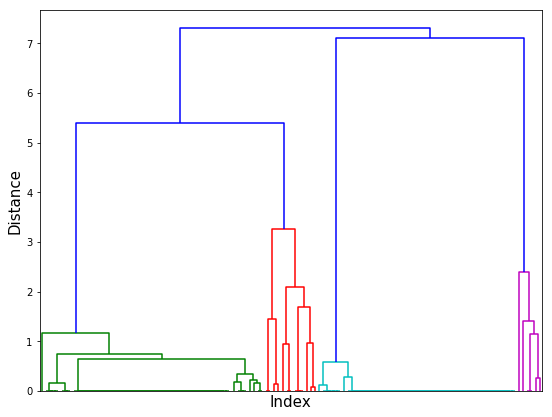

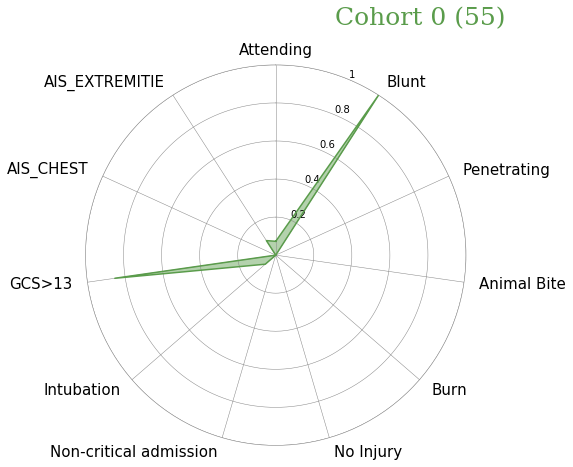

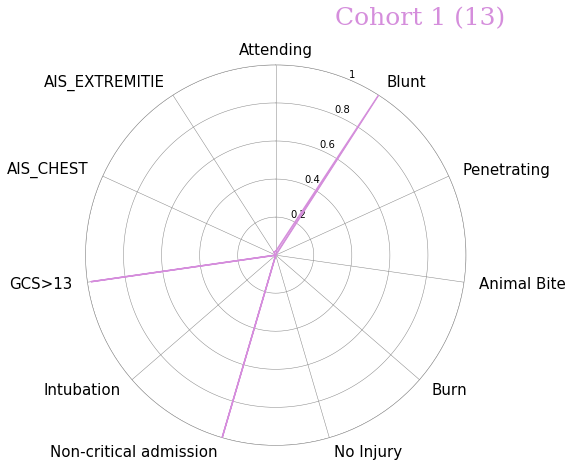

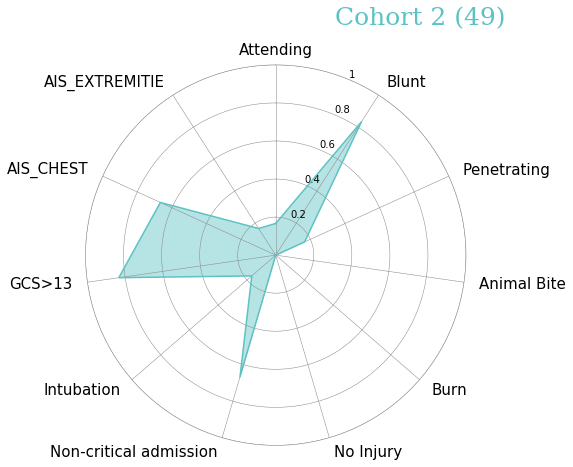

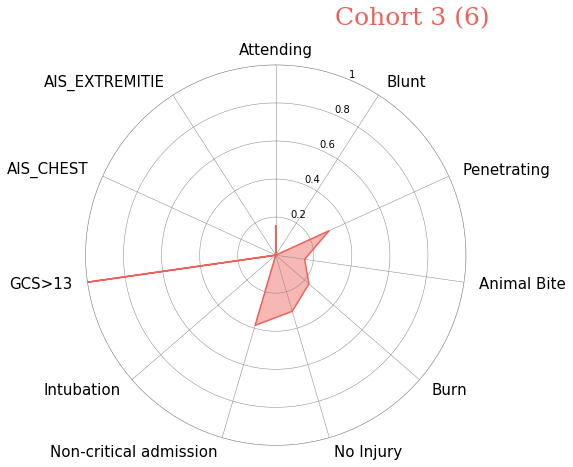

In [13]:
if __name__ =='__main__':
    filename = "Normalized_attributes.csv"
    
    main(filename)